# Как выбирать размер выборки

*Подготовил Ян Пиле*

Часто, когда собираются проводить АБ-тест, процесс происходит следующим образом:
    
1) К вам приходит менеджер и говорит: "Хочу провести АБ с нововведением Х и увеличить тем самым метрику Y" (например $X = \text{новый алгоритм ранжирования в ленте новостей}$, а $Y = CTR$\)

2) "А какой размер эффекта мы хотим увидеть?"-, спрашиваете Вы.

3) "Какой будет, такой и хотим увидеть,"- отвечает менеджер

Естественно, так ничего не заработает :) Очевидно вы понимаете, что для измерения любого сколь угодно малого эффекта вам нужно иметь бесконечное количество пользователей и, вероятно, бесконечное время проводить эксперимент.

Так что же, в итоге, делать?

# Калькуляторы размеров выборки

In [3]:
import pandahouse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import hashlib # Делать хеши
import swifter # Ускорялка метода apply
from scipy import stats # Статистика
from scipy.stats import norm, ttest_ind
%matplotlib inline

In [7]:
# Это мы в Clickhouse ходить будем
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}

Вероятно для оценки размера выборки вы видели вот такую формулу.

$$n > \frac{\left[ \Phi^{-1} \left( 1-\alpha \right) + \Phi^{-1} \left( 1-\beta \right) \right]^2 (\sigma_X^2 + \sigma_Y^2)}{\varepsilon^2}$$

Здесь $\varepsilon$ - размер эффекта, $\alpha$ - вероятность ошибки первого рода, $\beta$ - вероятность ошибки 2 рода

<img src = "https://alexanderdyakonov.files.wordpress.com/2019/05/d0b01.jpg?w=700">

Где здесь какая ошибка?

In [39]:
def compute_sample_size_abs(epsilon, std1, std2, alpha=0.05, beta=0.2):
    t_alpha = norm.ppf(1 - alpha / 2, loc=0, scale=1)
    t_beta = norm.ppf(1 - beta, loc=0, scale=1)
    z_scores_sum_squared = (t_alpha + t_beta) ** 2
    sample_size = int(
        np.ceil(
            z_scores_sum_squared * (std1 ** 2 + std2 ** 2) / (epsilon ** 2)
        )
    )
    return sample_size

# Как на самом деле сосчитать размер выборки. 

## Допустим, мы считаем наш CTR

[График про CTR](https://redash.lab.karpov.courses/queries/16866/source?p_date=2021-11-10--2021-11-10&p_exp_groups=%5B%222%22%2C%221%22%2C%223%22%2C%224%22%5D#35508)

[График про views](https://redash.lab.karpov.courses/queries/16866/source?p_date=2021-11-08--2021-11-14&p_exp_groups=%5B%222%22%2C%221%22%2C%223%22%2C%224%22%5D#35508)

In [206]:
q = """
select views, count() as users
from (select  
    exp_group,
    user_id,
    sum(action = 'view') as views
from simulator.feed_actions
where toDate(time) between '2021-11-08' and '2021-11-14'
    and exp_group in (1,2,3,4,5)
group by exp_group, user_id
)
group by views
order by views
"""


views_distribution = pandahouse.read_clickhouse(q, connection=connection)

In [207]:
views_distribution.users.sum()

34101

In [208]:
views_distribution['p'] = views_distribution['users']/views_distribution.users.sum()

In [210]:
views_distribution.sort_values(by = 'p', ascending = False)

,views,users,p
15,16,427,0.012522
14,15,420,0.012316
16,17,420,0.012316
13,14,394,0.011554
30,31,394,0.011554
...,...,...,...
287,289,1,0.000029
288,290,1,0.000029
291,293,1,0.000029
292,294,1,0.000029


## Вот наше настоящее распределение просмотров

In [211]:
views_distr = stats.rv_discrete(name='views_distr', 
                                values=(views_distribution['views'], 
                                        views_distribution['p']))

У $CTR$ разброс где-то от 0.2 до 0.22 по дням. Запомним это)

Достанем распределение CTR'ов за неделю

In [212]:
q = """
select 
   floor(ctr, 2) as ctr, count() as users
from (select toDate(time) as dt, 
    exp_group,
    user_id,
    sum(action = 'like')/sum(action = 'view') as ctr
from simulator.feed_actions
where dt between '2021-11-08' and '2021-11-14'
    and exp_group in (1,2,3,4,5)
group by dt, exp_group, user_id
)
group by ctr
"""


ctr_distribution = pandahouse.read_clickhouse(q, connection=connection)
ctr_distribution['p'] = ctr_distribution['users']/ctr_distribution.users.sum()

In [213]:
probabilities = ctr_distribution['p']
values = ctr_distribution['ctr']
distrib = stats.rv_discrete(values=(range(len(probabilities)), probabilities))

def get_ctrs(x, y):
    idx = distrib.rvs(size=x*y)
    result = values[idx]
    return np.array(result).reshape(x,y)

Так, средний CTR у нас был 0.21. допустим, мы хотим замечать изменение на 0.01 (то есть это на 5%)

# Синтетический А-А тест

In [214]:
q = """
select 
   stddevPop(ctr) as ctr_std
from (select toDate(time) as dt, 
    exp_group,
    user_id,
    sum(action = 'like')/sum(action = 'view') as ctr
from simulator.feed_actions
where dt between '2021-11-08' and '2021-11-14'
    and exp_group in (1,2,3,4,5)
group by dt, exp_group, user_id
)

"""

std = pandahouse.read_clickhouse(q, connection=connection).values[0][0]
std

0.0960017672016029

In [215]:
compute_sample_size_abs(0.01, std, std)

1447

In [225]:
group_A_views = views_distr.rvs(size = (2000, 2000))
group_B_views = views_distr.rvs(size = (2000, 2000))
group_A_ctr = get_ctrs(2000, 2000)*1.05
group_B_ctr = get_ctrs(2000,2000)
clicks_A = stats.binom.rvs(group_A_views, group_A_ctr)
clicks_B = stats.binom.rvs(group_B_views, group_B_ctr)

In [220]:
def t_test(a, b):
    """
    Считает p-value для t-теста с двусторонней альтернативой 
    :param a: np.array вида (n_experiments, n_users), значения метрик в контрольных группах
    :param b: np.array вида (n_experiments, n_users), значения метрик в тестовых группах
    :return: np.array вида (n_experiments), посчитанные p-value t-теста для всего списка экспериментов
    """
    result = list(map(lambda x: stats.ttest_ind(
        x[0], x[1]).pvalue, zip(a, b)))
    return np.array(result)

In [226]:
np.sum(t_test(clicks_A/group_A_views, clicks_B/group_B_views)<= 0.05)/2000

0.8405

In [108]:
t_test(clicks_A, clicks_B).shape

(10000,)

# Бакетное преобразование

In [228]:
def bucketization(ctrs_0, weights_0, ctrs_1, weights_1, n_buckets=100):
    """
    Разбиваем на бакеты с весами
    :param ctrs_0: np.array shape (n_experiments, n_users), CTRs of every user from control group in every experiment
    :param weights_0: np.array (n_experiments, n_users), веса пользователей в контрольной группе
    :param ctrs_1: np.array (n_experiments, n_users), CTRs of every user from treatment group in every experiment
    :param weights_1: np.array (n_experiments, n_users), веса пользователей в целевой группе
    :param n_buckets: int, кол-во бакетов
    :return: np.array shape (n_experiments), средневзвешенные метрики в каждом бакете
    """

    n_experiments, n_users = ctrs_0.shape

    values_0 = np.zeros((n_experiments, n_buckets))
    values_1 = np.zeros((n_experiments, n_buckets))

    for b in np.arange(n_buckets):
        ind = np.arange(b * n_users / n_buckets, b * n_users / n_buckets + n_users / n_buckets).astype(np.int)
        values_0[:, b] = np.sum(ctrs_0[:, ind] * weights_0[:, ind], axis=1) / np.sum(weights_0[:, ind], axis=1)
        values_1[:, b] = np.sum(ctrs_1[:, ind] * weights_1[:, ind], axis=1) / np.sum(weights_1[:, ind], axis=1)

    return values_0, values_1

In [229]:
# t-тест поверх бакетов
def t_test_buckets(ctrs_0, weights_0, ctrs_1, weights_1, n_buckets=100):
    return t_test(*bucketization(ctrs_0, weights_0, ctrs_1, weights_1, n_buckets))

# тест Манна-Уитни поверх бакетов
def mannwhitney_buckets(ctrs_0, weights_0, ctrs_1, weights_1, n_buckets=100):
    return mannwhitney(*bucketization(ctrs_0, weights_0, ctrs_1, weights_1, n_buckets))

In [230]:
p_values_ab = mannwhitney_buckets(
        clicks_A/group_A_views, group_A_views,
        clicks_B/group_B_views, group_B_views)

In [232]:
np.sum(p_values_ab<= 0.05)/2000

0.745

# Линеаризация

In [233]:
group_A_views = views_distr.rvs(size = (2000, 2000))
group_B_views = views_distr.rvs(size = (2000, 2000))
group_A_ctr = get_ctrs(2000, 2000)*1.05
group_B_ctr = get_ctrs(2000,2000)
clicks_A = stats.binom.rvs(group_A_views, group_A_ctr)
clicks_B = stats.binom.rvs(group_B_views, group_B_ctr)

In [234]:
control_ctr = stats.binom.rvs(group_B_views, group_B_ctr).sum(axis = 1)/group_B_views.sum(axis = 1)

In [235]:
linearized_A = clicks_A - (group_A_views.T*control_ctr).T
linearized_B = clicks_B - (group_B_views.T*control_ctr).T

In [236]:
linearization_p_values = t_test(linearized_A, linearized_B)

In [238]:
sum(linearization_p_values<=0.05)/2000

0.777

# А на самом деле просмотры обычно выглядят не так...

In [239]:
mu = 1
sigma2 = 1.5
N = 1447
experiments = 1000
views_lognormal = np.absolute(np.exp(norm(mu, sigma2).rvs(
    experiments * N)).astype(np.int64).reshape(experiments, N) + 1)

Text(0.5, 1.0, 'Views, 99%-ile = 90.0   ')

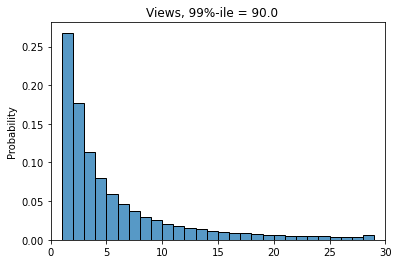

In [240]:
fig = plt.figure()
ax_views = fig.add_subplot()
views_distr = sns.histplot(views_lognormal.ravel(),  # Теперь это массив длины experiments * N
                           bins=range(0, 30),
                           kde=False,
                           ax=ax_views,
                           stat='probability')
ax_views.set_xlim((0, 30))
views_99_percentile = np.percentile(views_lognormal.ravel(), 99)
ax_views.set_title(f'Views, 99%-ile = {views_99_percentile:<7.1f}')

In [241]:
def get_views(experiments, N, mu = 1, sigma = 1.5):
    views_lognormal = np.absolute(
        np.exp(
            norm(mu, 
                 sigma2).rvs(experiments * N)
        ).astype(np.int64).reshape(experiments, N) + 1)
    return views_lognormal

In [251]:
group_A_views = get_views(2000, 11000)
group_B_views = get_views(2000, 11000)
group_A_ctr = get_ctrs(2000, 11000)*1.05
group_B_ctr = get_ctrs(2000,11000)
clicks_A = stats.binom.rvs(group_A_views, group_A_ctr)
clicks_B = stats.binom.rvs(group_B_views, group_B_ctr)

In [248]:
compute_sample_size_abs(0.01, 0.278, 0.278)

12132

In [249]:
(clicks_B/group_B_views).std(axis = 1)[0]

0.276386468691738

In [252]:
np.sum(t_test(clicks_A/group_A_views, clicks_B/group_B_views)<= 0.05)/2000

0.793

In [253]:
np.sum(t_test_buckets(clicks_A/group_A_views, 
                      group_A_views,
                      clicks_B/group_B_views, 
                      group_B_views)<= 0.05)/2000

0.813

# А если я хочу сдвинуть медиану ...

In [189]:
def bucketization_median(ctrs_0, ctrs_1, n_buckets=100):
    """
    Разбиваем на бакеты с весами
    :param ctrs_0: np.array shape (n_experiments, n_users), CTRs of every user from control group in every experiment
    :param weights_0: np.array (n_experiments, n_users), веса пользователей в контрольной группе
    :param ctrs_1: np.array (n_experiments, n_users), CTRs of every user from treatment group in every experiment
    :param weights_1: np.array (n_experiments, n_users), веса пользователей в целевой группе
    :param n_buckets: int, кол-во бакетов
    :return: np.array shape (n_experiments), средневзвешенные метрики в каждом бакете
    """

    n_experiments, n_users = ctrs_0.shape

    values_0 = np.zeros((n_experiments, n_buckets))
    values_1 = np.zeros((n_experiments, n_buckets))

    for b in np.arange(n_buckets):
        ind = np.arange(b * n_users / n_buckets, b * n_users / n_buckets + n_users / n_buckets).astype(np.int)
        values_0[:, b] = np.median(ctrs_0[:, ind], axis=1)
        values_1[:, b] = np.median(ctrs_1[:, ind], axis=1)

    return values_0, values_1

In [196]:
def mannwhitney(a, b):
    """
    Двусторонний тест Манна-Уитни
    :param a: np.array вида (n_experiments, n_users), значения метрики в контроле
    :param b: np.array вида (n_experiments, n_users), значен я метрики в тесте
    :return: np.array вида (n_experiments), двусторонние p-value методом Манна-Уитни для всех экспериментов
    """
    result = list(map(lambda x: stats.mannwhitneyu(
        x[0], x[1], alternative='two-sided').pvalue, zip(a, b)))
    return np.array(result)

def mannwhitney_median_buckets(ctrs_0, ctrs_1, n_buckets=100):
    return mannwhitney(*bucketization_median(ctrs_0, ctrs_1, n_buckets))

In [197]:
np.sum(mannwhitney_median_buckets(clicks_A/group_A_views,clicks_B/group_B_views)<= 0.05)

1172